In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
#from __future__ import unicode_literals

import copy
from collections import namedtuple
from collections import OrderedDict
import shelve

import pylab as pl

import pykat
from pykat.components import *
from pykat.external.progressbar import ProgressBar, ETA, Percentage, Bar, Timer
from pykat.optics.maps import *
from pykat.optics.gaussian_beams import HG_mode, beam_param
from pykat.optics.fft import *
#from pykat.tools.plotting.tools import plot_field, plot_propagation

from aligo import *

import matplotlib.pyplot as plt
%matplotlib inline

                                              ..-
    PyKat 1.0.14          _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
class pp():
    # set some gobal settings first
    BACKEND = 'Qt4Agg' # matplotlib backend
    FIG_DPI=90 # DPI of on sceen plot
    # Some help in calculating good figure size for Latex
    # documents. Starting with plot size in pt,
    # get this from LaTeX using \showthe\columnwidth
    fig_width_pt = 484.0
    inches_per_pt = 1.0/72.27  # Convert TeX pt to inches
    golden_mean = (np.sqrt(5)-1.0)/2.0   # Aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*golden_mean      # height in inches
    fig_size = [fig_width,fig_height]
    # some plot options:
    LINEWIDTH = 1 # linewidths of traces in plot
    AA = True # antialiasing of traces
    USETEX = False # use Latex encoding in text
    SHADOW = False # shadow of legend box
    GRID = True # grid on or off
    # font sizes for normal text, tick labels and legend
    FONT_SIZE = 10 # size of normal text
    TICK_SIZE = 10 # size of tick labels
    LABEL_SIZE = 10 # size of axes labels
    LEGEND_SIZE = 10 # size of legend
    # font family and type
    font = {'family':'sans-serif','sans-serif':['Helvetica'],'size':FONT_SIZE}
    DPI=300 # DPI for saving via savefig
    # print options given to savefig command:
    print_options = {'dpi':DPI, 'transparent':True, 'bbox_inches':'tight', 'pad_inches':0.1}
    # for Palatino and other serif fonts use:
    #font = {'family':'serif','serif':['Palatino']}
    SCREEN_TITLE = True # show title on screen?
    PRINT_TITLE = False # show title in saved file?
    
    
def plot_setup():
    from matplotlib import rc
    rc('font',**pp.font)
    rc('xtick',labelsize=pp.TICK_SIZE)
    rc('ytick',labelsize=pp.TICK_SIZE)
    rc('text', usetex=pp.USETEX)
    rc('axes', labelsize = pp.LABEL_SIZE)
    fig, ax =plt.subplots()
    fig.set_size_inches(pp.fig_size)
    fig.set_dpi(pp.FIG_DPI)
    return ax,fig

def plot_field(field):
    ax,fig=plot_setup()
    im = ax.imshow(np.abs(field),origin='lower', aspect='auto')
    cb = fig.colorbar(im, format="%.4g")
    #cb.set_clim(-1.0*zlimit, zlimit)
    ax.autoscale(False)#
    plt.show(block=0)

def plot_propagation(field, grid, Lambda, axis, normalise, Lrange, nr):
    # axis = 0 for x and =1 for y crosssection
    # if normalise = 1, each slice is normalises to peak intensity
    [n,m]=field.shape
    slices = np.zeros((n,np.size(Lrange)))
    from pykat.optics.fft import FFT_propagate
    for idx, L in enumerate(Lrange):
        field2 = FFT_propagate(field,grid, Lambda, L, nr)
        if axis==0:
            slices[:,idx]=np.abs(field2[:,int(m/2)])**2
        else:
            slices[:,idx]=np.abs(field2[int(n/2),:])**2
        if normalise==1:
            peak_intensity= np.abs(field2[int(n/2),int(m/2)])**2
            slices[:,idx]=slices[:,idx]/peak_intensity
    ax,fig=plot_setup()
    im = ax.imshow(slices, aspect='auto')
    cb = fig.colorbar(im, format="%.4g")
    #cb.set_clim(-1.0*zlimit, zlimit)
    ax.autoscale(False)
    plt.show(block=0)
    
def FFT_apply_map(field, Map, Lambda):
    k=2.0*np.pi/Lambda
    return field*np.exp(-1j * 2.0 * k * Map.data*Map.scaling);

In [3]:
tmpresultfile = 'myshelf1.dat'
result={}

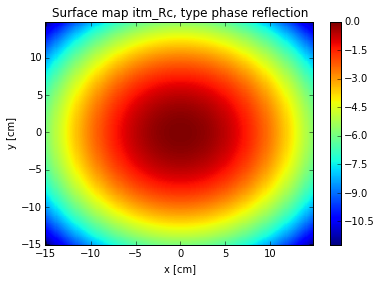

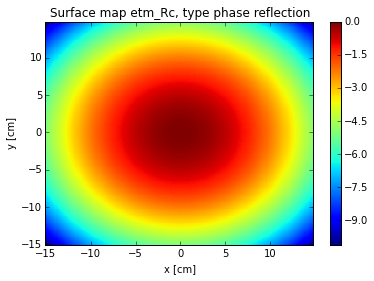

In [4]:
# loading kat file to get parameters and to compute input beam parameters
global kat, out
kat = pykat.finesse.kat()
kat.verbose = False
kat.loadKatFile('aligo_Xarm.kat')

# setting ITM T to larger value for better plots
kat.itmX.T=0.1
kat.itmX.R=0.9
Lambda = kat.lambda0
LX=kat.LX.L.value
kat.maxtem=0
out = kat.run()
w0=out.y[0][0]
z0=-out.y[0][1]

# load and create mirror maps
global itm, etm
surface=read_map('etm08_virtual.txt')
itm=curvedmap('itm_Rc',surface.size,surface.step_size, -1.0*abs(kat.itmX.Rc.value))
etm=curvedmap('etm_Rc',surface.size,surface.step_size, -1.0*abs(kat.etmX.Rc.value))
# apply measured map to etm, using 20 times larger distortions
etm.data = etm.data + surface.data*surface.scaling/etm.scaling*20

# plot mirror maps
itm.plot();
etm.plot();

In [5]:
# setup grid for FFT propagation
[xpoints,ypoints] = surface.size
xsize = xpoints * surface.step_size[0]
ysize = ypoints * surface.step_size[1]
xoffset = 0.0
yoffset = 0.0
global shape
shape = grid(xpoints, ypoints, xsize, ysize, xoffset, yoffset)
x = shape.xaxis
y = shape.yaxis
result['shape']=shape

In [6]:
# generate roughly mode-matched input beam
global laser
gx = beam_param(w0=w0, z=z0)
beam = HG_mode(gx,gx,0,0)
laser = beam.Unm(x,y) 

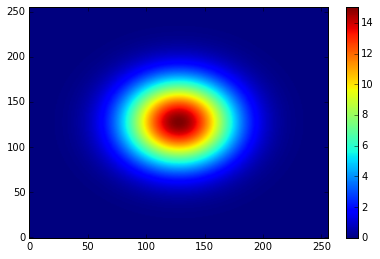

In [7]:
plot_field(laser)

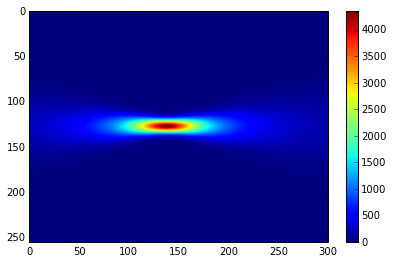

In [8]:
Lrange= np.linspace(0,4000,300)
plot_propagation(laser, shape, Lambda, 0, 0, Lrange, 1)

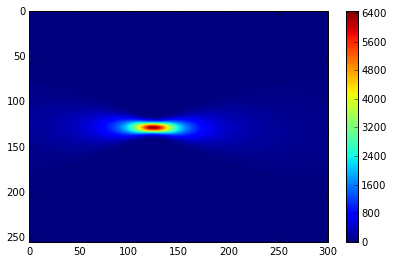

In [9]:
laser1=FFT_propagate(laser,shape,Lambda,LX,1)
laser2=np.sqrt(kat.etmX.R.value)*FFT_apply_map(laser1, etm, Lambda)
laser3=FFT_propagate(laser2,shape,Lambda,LX,1)
laser4=np.sqrt(kat.itmX.R.value)*FFT_apply_map(laser1, itm, Lambda)
Lrange= np.linspace(0,4000,300)
plot_propagation(laser4, shape, Lambda, 0, 0, Lrange, 1)

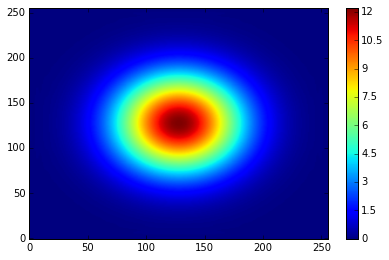

In [10]:
plot_field(laser4)

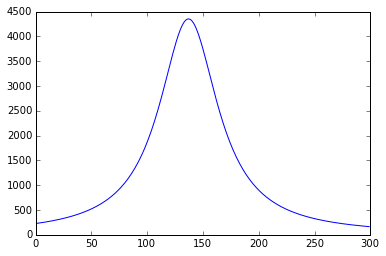

In [11]:
[n,m]=laser.shape
slices = np.zeros((n,np.size(Lrange)))
peaks = []
for idx, L in enumerate(Lrange):
    field2 = FFT_propagate(laser,shape, Lambda, L, 1)
    slices[:,idx]=np.abs(field2[:,int(m/2)])**2
    peak_intensity= np.abs(field2[int(n/2),int(m/2)])**2
    peaks.append(peak_intensity)
    slices[:,idx]=slices[:,idx]/peak_intensity
plt.plot(peaks);

In [12]:
# Required number of round-trips for accuracy
R=kat.etmX.R.value*kat.itmX.R.value
Loss = 1-R
accuracy=100E-6
N=int(2*math.ceil(np.log(0.5*accuracy)/np.log(R)))
N

188

In [13]:
global f_round
f_circ=np.zeros((shape.xpoints,shape.ypoints),dtype=np.complex128)
f_round=np.zeros((shape.xpoints,shape.ypoints,N),dtype=np.complex128)

# move impinging field into cavity
f_circ = np.sqrt(kat.itmX.T.value) * laser
# this counts as the first (zeroth) roundtrip
f_round[:,:,0] = f_circ

In [14]:
for n in range(1,N):
    #f_circ = FFT_propagate(f_circ,shape,Lambda,LX,1) 
    f_circ = FFT_propagate_simple(f_circ,shape.xpoints,shape.ypoints, shape.xstep, shape.ystep,Lambda,LX,1) 
    f_circ = np.sqrt(kat.etmX.R.value)*FFT_apply_map(f_circ, etm, Lambda)
    #f_circ = FFT_propagate(f_circ,shape,Lambda,LX,1) 
    f_circ = FFT_propagate_simple(f_circ,shape.xpoints,shape.ypoints, shape.xstep, shape.ystep,Lambda,LX,1) 
    f_circ = np.sqrt(kat.itmX.R.value)*FFT_apply_map(f_circ, itm, Lambda)
    f_round[:,:,n] = f_circ;

In [15]:
scan_start = 0.0
scan_stop  = Lambda
scan_points = 100
global scan
scan = np.linspace(scan_start, scan_stop, scan_points)

global power
f_temp=np.zeros(np.shape(f_round[:,:,0]))
power=np.zeros(scan_points,dtype=np.double)

def field_power(field, shape):
    return np.sum(np.abs(field)**2)*shape.xstep*shape.ystep;

/Users/mxd501/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


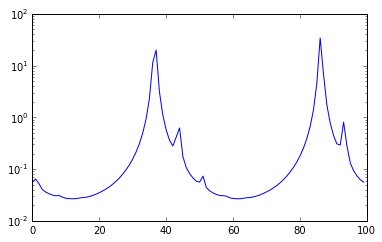

In [16]:
global phases
k = 2.0*np.pi/Lambda
ns=np.linspace(0.0, N-1, N)
for i in range(scan_points):
    phases=np.exp(1j*2.0*k*scan[i]*ns)
    f_temp=np.sum(f_round*phases,axis=-1)
    power[i] = field_power(f_temp,result['shape'])
    
fig=pykat.plotting.figure()
ax=fig.add_subplot(111)
ax.plot(power)
ax.set_yscale('log')
pl.draw()
pl.show(block=0)